# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [ ]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [ ]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 90 (delta 33), reused 74 (delta 20), pack-reused 0
Receiving objects: 100% (90/90), 1.42 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
import os
from glob import glob
from io import open
import string

def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Italian.txt', './data/Names/Arabic.txt']


In [ ]:
!rm -r pytorch-tutorial-nlp-public/

In [ ]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abbà', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abelló', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airò', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Albero', 'Albini', 'Albricci', 'Albrici', 'Alcheri', 'Aldebrandi', 'Alderisi', 'Alduino', 'Alemagna', 'Alep

In [ ]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Italian': ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abbà', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abelló', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airò', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Albero', 'Albini', 'Albricci', 'Albrici', 'Alcheri', 'Aldebrandi', 'Alderisi', 'Alduino', 'Alem

In [ ]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [ ]:
import torch

def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters)
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

'''__COMPLETE_HERE__'''

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [ ]:
class RNN(self, '''__COMPLETE_HERE__'''):
  def __init__(self, '''__COMPLETE_HERE__'''):
    super(RNN, self).__init__()

    '''__COMPLETE_HERE__'''

  def forward(self, '''__COMPLETE_HERE__'''):
    '''__COMPLETE_HERE__'''

In [ ]:
class RNNEmb(self, '''__COMPLETE_HERE__'''):
  def __init__(self, '''__COMPLETE_HERE__'''):
    super(RNNEmb, self).__init__()

    '''__COMPLETE_HERE__'''

  def forward(self, '''__COMPLETE_HERE__'''):
    '''__COMPLETE_HERE__'''

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [ ]:
class LSTM(self, '''__COMPLETE_HERE__'''):
  def __init__(self, '''__COMPLETE_HERE__'''):
    super(LSTM, self).__init__()

    '''__COMPLETE_HERE__'''

  def forward(self, '''__COMPLETE_HERE__'''):
    '''__COMPLETE_HERE__'''

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    # print(top_val)
    # print(top_idx)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [ ]:
print(all_categories)

['Italian', 'Arabic', 'Portuguese', 'Irish', 'Polish', 'Scottish', 'English', 'Korean', 'Japanese', 'Chinese', 'Dutch', 'Czech', 'French', 'German', 'Vietnamese', 'Greek', 'Spanish', 'Russian']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [ ]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    word_tensor = wordToOneHotTensor(word)
    '''__COMPLETE_HERE__'''
    return category, word, category_tensor, word_tensor

for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample()
    print('Category: ' + category)
    print('Word: ' + word)

Category: German
Word: Carver
Category: Russian
Word: Mombelli
Category: Russian
Word: Chkhenkeli
Category: Irish
Word: Flann


### Training the Network
 In the following change the initialisation with the model you want to use.




In [ ]:
n_hidden = 128

# change the model with the model you want to use
rnn = RNN('''__COMPLETE_HERE__''')

criterion = nn.NLLLoss()

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.

What is the other problem this kind of network has? And what are the possible solutions?

In [ ]:
from torch import optim

learning_rate = 0.005
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate)
#optimizer = optim.Adam(rnn.parameters(), lr = learning_rate)

def train(category_tensor, word_tensor):

    hidden = None
    cell = None

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):
      # modify the following with the correct implementation depending on the
      # network you are using
      output, hidden = rnn('''COMPLETE_HERE''')


    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, word, category_tensor, word_tensor = randomTrainingExample()

    output, loss = train(category_tensor, word_tensor)
    current_loss += loss

    if iter % print_every == 0:
        category_pred, category_idx = categoryFromOutput(output)
        correct = 'OK' if category_pred == category else 'NO (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

    # add the current loss to the list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




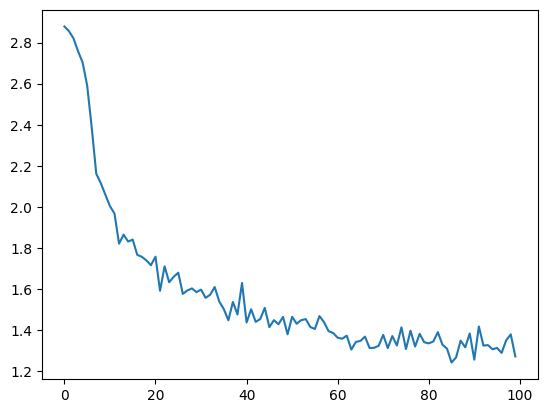

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = None
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [ ]:
def getTrainingSample(word):
    # create a long tensor with the index of the language
    word_tensor = wordToOneHotTensor(word)
    return word_tensor

def get_embedding(mapping : dict, model):
  ''' COMPLETE_HERE '''
  return hiddens, words, languages




In [ ]:
from sklearn.manifold import TSNE
viz_words = 100
indices = np.random.choice(hiddens.shape[0], viz_words)


In [ ]:

colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

tsne = TSNE()
#embed_tsne = tsne.fit_transform(hiddens.squeeze()[:,:])
embed_tsne = tsne.fit_transform(hiddens.squeeze()[indices,:])

fig, ax = plt.subplots(figsize=(12, 12))
for i, val in enumerate(indices):
    key_index = list(category_words.keys()).index(languages[val])

    plt.scatter(*embed_tsne[i, :], color=colors[key_index])
    plt.annotate(words[val]+' ('+languages[val]+')', (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)
